In [1]:
import os 
import numpy as np  
import matplotlib.pyplot as plt
from locscale.include.emmer.ndimage.profile_tools import compute_radial_profile, frequency_array
import gemmi 
from locscale.include.emmer.ndimage.map_utils import load_map, save_as_mrc

In [34]:
hybrid_pdb_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/pseudomodel_during_iterations/hybrid_pseudomodel_iterations/overfitting_analysis/cropped_model_pdb_5vkq_integrated_pseudoatoms.cif"
#model_map_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/pseudomodel_during_iterations/hybrid_pseudomodel_iterations/overfitting_analysis/refmac_iteration_analysis_output_30/model_maps/model_map_cycle_10.mrc"
model_map_path = "/home/abharadwaj1/papers/elife_paper/figure_information/outputs/feature_enhance_test_maps_hybrid_60k/8702_5vkq/emd_8702_emmernet_output_mean.mrc"

modelmap, apix = load_map(model_map_path)
st = gemmi.read_structure(hybrid_pdb_path)

[[235.247, 274.241, 310.439], [270.708117, 291.927911, 226.034713]]
[[255, 226, 194], [186, 240, 223]]


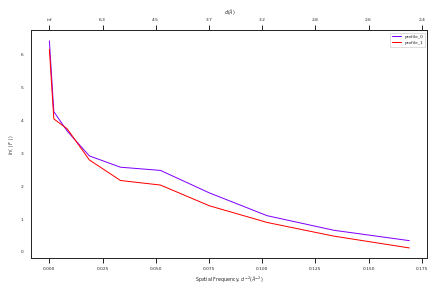

In [35]:
from locscale.include.emmer.ndimage.map_utils import convert_pdb_to_mrc_position
from locscale.include.emmer.ndimage.map_utils import extract_window 
from locscale.include.emmer.ndimage.plots import plot_radial_profile 

chain_name_1 = "B"
res_id_1 = 536

chain_name_2 = "I"
res_id_2 = 3111

pdb_positions = [st[0][chain_name_1][res_id_1][0].pos.tolist(), st[0][chain_name_2][res_id_2][0].pos.tolist()]
mrc_positions = convert_pdb_to_mrc_position(pdb_positions, apix)

print(pdb_positions)                
print(mrc_positions)


window_size = int(25 / apix)

window_1 = extract_window(modelmap, mrc_positions[0], window_size)
window_2 = extract_window(modelmap, mrc_positions[1], window_size)

rp_1 = compute_radial_profile(window_1)
rp_2 = compute_radial_profile(window_2)

freq_1 = frequency_array(rp_1, apix)

fig = plot_radial_profile(freq_1, [rp_1, rp_2])

In [36]:

#    
def pretty_plot_radial_profile(freq,list_of_profiles_native, plot_type="make_log", \
                                legends=None,figsize_cm=(14,8), fontsize=10,linewidth=1, \
                                marker="o", markersize=5,font="Helvetica",fontscale=1, showlegend=True, showPoints=False, \
                                alpha=1, variation=None, yticks=None, ylims=None, xlims=None, crop_freq=None, labelsize=None, title=None):
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import cm
    from locscale.include.emmer.ndimage.profile_tools import crop_profile_between_frequency
    import seaborn as sns
    import matplotlib 
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    # set the global font size for the plot

        
    plt.rcParams.update({'font.size': fontsize})
    figsize = (figsize_cm[0]/2.54, figsize_cm[1]/2.54) # convert cm to inches
    
    fig, ax1 = plt.subplots(figsize=figsize, dpi=600)  # DPI is fixed to 600 for publication quality
    sns.set_theme(context="paper", font=font, font_scale=fontscale)
    # Set font size for all text in the figure
    sns.set_style("white")

    if isinstance(freq, list):
        list_of_freq = freq
    else:
        list_of_freq = [freq]*len(list_of_profiles_native)
    
    # Crop frequencies if required
    if crop_freq is not None:
        cropped_frequency_list = [crop_profile_between_frequency(f, list_of_profiles_native[0], crop_freq[0], crop_freq[1])[0] for f in list_of_freq]
        cropped_profiles = [crop_profile_between_frequency(list_of_freq[0], profile, crop_freq[0], crop_freq[1])[1] for profile in list_of_profiles_native]
    else:
        cropped_frequency_list = list_of_freq
        cropped_profiles = list_of_profiles_native
    
    final_list_of_profiles = []

    for profile in cropped_profiles:
        if plot_type=="make_log":
            profile = np.log(profile)
            plot_frequency_axis_list = [cropped_frequency**2 for cropped_frequency in cropped_frequency_list]
        elif plot_type=="squared_amp":
            profile = np.log(profile**2)
            plot_frequency_axis_list = [cropped_frequency**2 for cropped_frequency in cropped_frequency_list]
        elif plot_type=="normalise":
            profile = profile/profile.max()
            plot_frequency_axis_list = cropped_frequency_list
        else:
            plot_frequency_axis_list = cropped_frequency_list        
    
        final_list_of_profiles.append(profile)
        
    
    # Add labels to the plot
    xlabel_top = r'Resolution, $d (\AA)$'
    if plot_type=="normalise":
        xlabel = r'Spatial Frequency, $d^{-1} (\AA^{-1})$'
        ylabel = r'Normalised $ \langle \mid F \mid \rangle $'
    elif plot_type=="squared_amp":
        xlabel = r'Spatial Frequency, $d^{-2} (\AA^{-2})$'
        ylabel = r'$ln  \langle \mid F \mid ^{2} \rangle $ '
    elif plot_type=="make_log":
        xlabel = r'Spatial Frequency, $d^{-2} (\AA^{-2})$'
        ylabel = r'$ln  \langle \mid F \mid \rangle $'
    else:
        xlabel = r'Spatial Frequency, $d^{-1} (\AA^{-1})$'
        ylabel = r'$ \langle \mid F \mid \rangle $'
    # Map the colors
    
    colors = cm.rainbow(np.linspace(0,1,len(final_list_of_profiles)))
    
    ax1.grid(False)
    ax2 = ax1.twiny()

    for i, profile in enumerate(final_list_of_profiles):
        if showPoints:
            ax1.plot(plot_frequency_axis_list[i], profile, marker=marker, markersize=markersize, color=colors[i], alpha=alpha, \
                        linewidth=linewidth, label=legends[i])
        else:
            ax1.plot(plot_frequency_axis_list[i], profile, color=colors[i], alpha=alpha, linewidth=linewidth, label=legends[i])
                
    ax2.set_xticks(ax1.get_xticks())
    ax2.set_xbound(ax1.get_xbound())
    ax2.set_xticklabels([round(1/np.sqrt(x),1) for x in ax1.get_xticks()])
    #ax2.tick_params(axis="both", which="both", labelsize=labelsize)

    if showlegend:
        ax1.legend(loc="best")
    ax1.set_xlabel(xlabel)#, fontsize=fontsize)
    ax1.set_ylabel(ylabel)#, fontsize=fontsize)
    #ax1.tick_params(axis="both", which="both", labelsize=labelsize)
    ax2.set_xlabel(xlabel_top)#, fontsize=fontsize)
    
    if ylims is not None:
        plt.ylim(ylims)
    if yticks is not None:
        plt.yticks(yticks)
    if xlims is not None:
        plt.xlim(xlims)

    if title is not None:
        plt.title(title)
    plt.tight_layout()
    return fig, ax1, ax2

/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in sqrt
/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in double_scalars


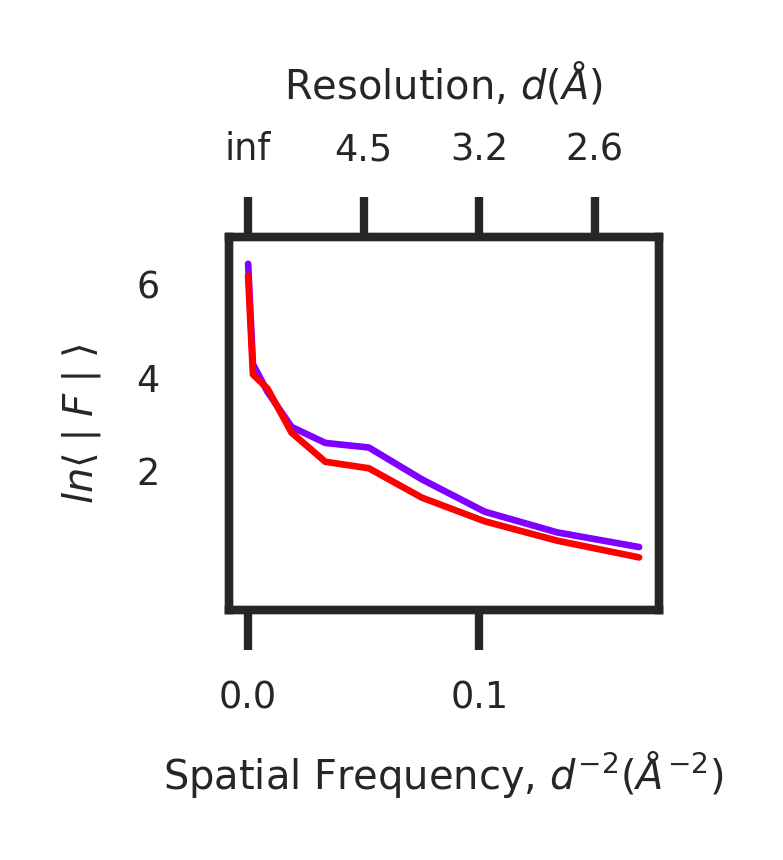

In [37]:
fig, ax1, ax2 = pretty_plot_radial_profile(freq_1, [rp_1, rp_2], plot_type="make_log", legends=["Residue 536", "Residue 1250"], \
                                figsize_cm=(2.9,3.5), fontsize=5,linewidth=0.8, \
                                marker="o", markersize=5,font="Helvetica",fontscale=0.5, showlegend=False, showPoints=False, \
                                alpha=1, variation=None, yticks=[2,4,6], ylims=[-1,7], xlims=None, crop_freq=None, labelsize=None, title=None)


In [38]:
output_dir = "/home/abharadwaj1/papers/elife_paper/figure_information/outputs"
figsavepath = os.path.join(output_dir, "radial_profile_hybrid_scaling_I3111_B536_predictedmap.eps")
fig.savefig(figsavepath, bbox_inches='tight')